In [1]:
import math
import pydicom
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

### Load Image

In [2]:
DICOM_PATH = "images/DICOMOBJ/test-L2"
IS_ROTATE = False 
# arrays = []

dicom_data = pydicom.dcmread(DICOM_PATH)
arr = dicom_data.pixel_array
if IS_ROTATE:
    arr = ndimage.rotate(arr, 90)

### Helper Functions

In [3]:
def inv_lut(arr: np.array):
    max_pixel = arr.max()
    min_pixel = arr.min()
    return max_pixel - arr + min_pixel

def display(arr: np.array, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.axis(axis)

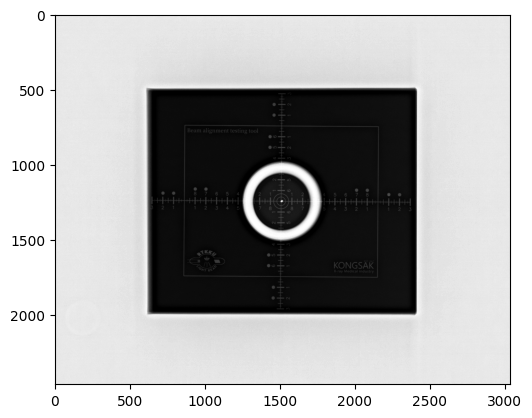

In [4]:
display(arr, True)

In [5]:
arr

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0, 15363, ..., 14615, 14301, 14558],
       ...,
       [    0,     0, 14958, ..., 14660, 14771, 14875],
       [    0,     0, 14460, ..., 15043, 14690, 14665],
       [    0,     0, 14078, ..., 14894, 14872, 15117]], dtype=uint16)

### Find Test-Tool

In [6]:
# assume crop if each size > 2,000 (not crop yet)
H, W = arr.shape
P = 0.24 # experimental number (Percent)
if (H*W) > (2000**2):
    arr = arr[int(H*P): int(H*(1-P)), int(W*P): int(W*(1-P))]
    H, W = arr.shape

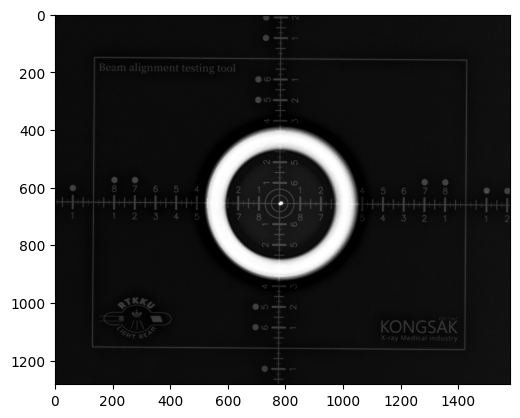

In [7]:
display(arr, True)

### Find Lines and Center of the Image

In [8]:
def most_common(focus_arr: np.array, axis=0) :
    """
    find most common pixel value in specific axis
    axis 0 = by col, axis 1 = by row
    return: most common pixel value
    """
    pixel_vals = np.argmax(focus_arr, axis=axis) # [b, w] color (if inv use argmin)
    unique_vals, counts = np.unique(pixel_vals, return_counts=True)
    most_common_idx = np.argmax(counts)
    pixel_val = unique_vals[most_common_idx]
    return pixel_val

- Find Center Line(Horizontal)

In [9]:
hp = int(0.2*H)
wp = int(0.06*W)

focus_l = arr[hp: H-hp, wp: wp*2]
focus_r = arr[hp: H-hp, W-(wp*2): W-wp]

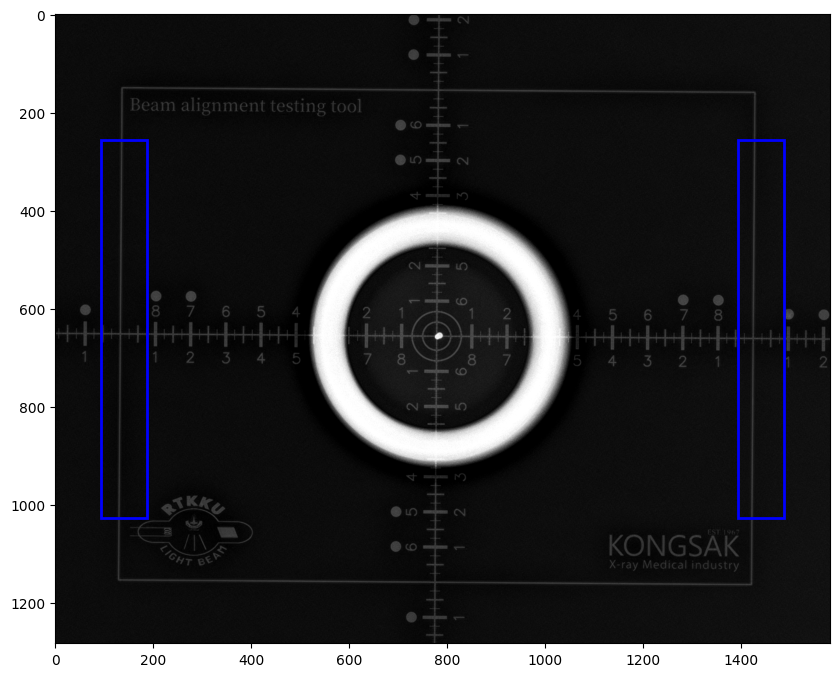

In [10]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(arr, cmap='gray')

# Top-Left(x, y), width, heigh
l_rec = patches.Rectangle((wp, hp), wp, H-2*hp, linewidth=2, edgecolor='blue', facecolor='none')
r_rec = patches.Rectangle((W-(wp*2), hp), (W-wp)-(W-(wp*2)), (H-hp)-hp, linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(l_rec)
ax.add_patch(r_rec)

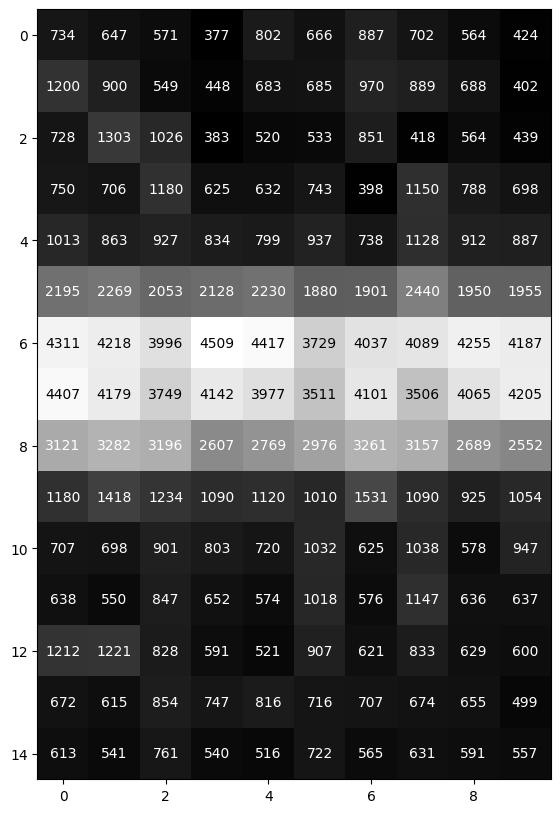

In [11]:
focus_v = arr[645: 660, 100: 110]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(focus_v, cmap='gray')

# Annotate each pixel with its value
for i in range(focus_v.shape[0]): 
    for j in range(focus_v.shape[1]):  
        text = f"{focus_v[i, j]}"
        if i == 6 or i == 7 :
            c = "black"
        else: 
            c = "white"
        ax.text(j, i, text, ha="center", va="center", color=c, fontsize=10)

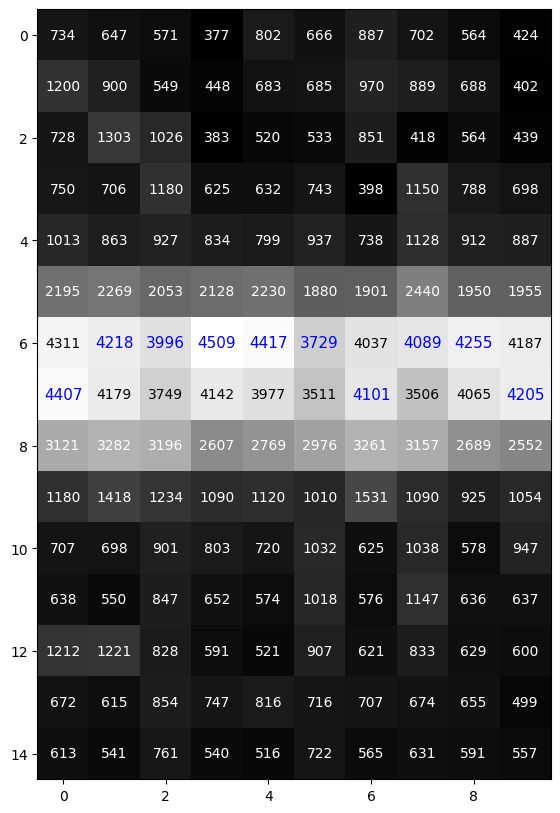

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(focus_v, cmap='gray')

max_c = np.argmax(focus_v, axis=0)
for i in range(focus_v.shape[0]): 
    for j in range(focus_v.shape[1]):  
        text = f"{focus_v[i, j]}"
        if i == 6 or i == 7 :
            c = "black"
        else: 
            c = "white"
        if i == max_c[j] :
            c = "blue"
            size = 11
        else :
            size = 10
        ax.text(j, i, text, ha="center", va="center", color=c, fontsize=size)

In [13]:
y1 = most_common(focus_l, axis=0) + hp # start at hp not 0
y2 = most_common(focus_r, axis=0) + hp 
y1, y2

(652, 661)

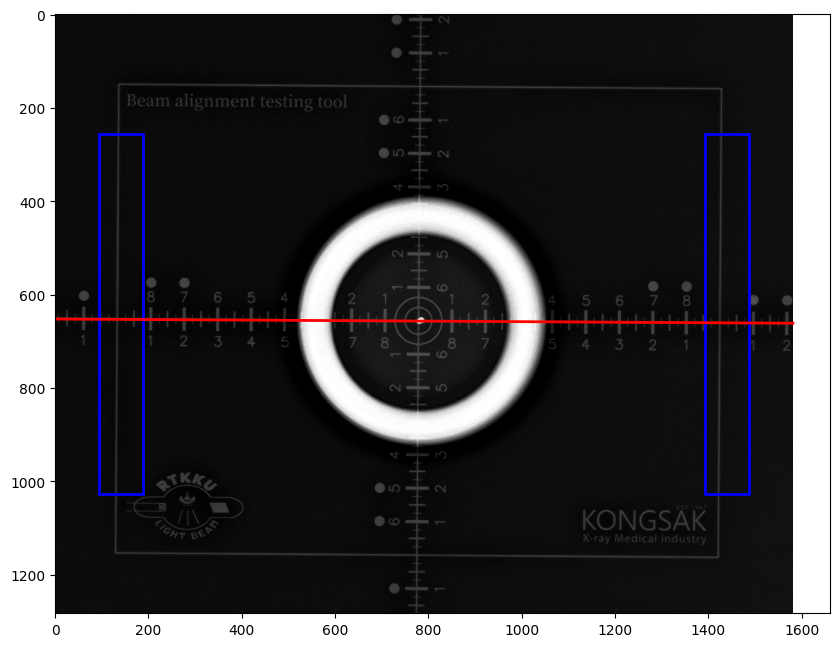

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(arr, cmap='gray')

# Top-Left(x, y), width, heigh
l_rec = patches.Rectangle((wp, hp), wp, H-2*hp, linewidth=2, edgecolor='blue', facecolor='none')
r_rec = patches.Rectangle((W-(wp*2), hp), (W-wp)-(W-(wp*2)), (H-hp)-hp, linewidth=2, edgecolor='blue', facecolor='none')
plt.plot([0, W], [y1, y2], linewidth=2, color="red")
ax.add_patch(l_rec)
ax.add_patch(r_rec)

In [15]:
def find_theta(x1, x2, y1, y2):
    """
    find theta from given width(x1, x2) and height(y1, y2)
    return: theta in degree
    """
    a = y2 - y1
    w = x2 - x1
    theta_r = math.atan(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [16]:
def find_center_line(arr: np.array):
    """
    find horizontal center line
    theta: alignment of the center line
    return (x1, y1), (x2, y2), (theta)
    """
    H, W = arr.shape
    hp = int(0.2*H)
    wp = int(0.06*W)

    # left point
    focus_l = arr[hp: H-hp, wp: wp*2]
    y1 = most_common(focus_l, axis=0) + hp
    
    # right point
    focus_r = arr[hp: H-hp, W-(wp*2): W-wp]
    y2 = most_common(focus_r, axis=0) + hp

    theta = find_theta(wp, W-(wp*2), y1, y2)
    
    return (0, y1), (W-1, y2), theta # W-1 for visualize not over blank

In [76]:
def draw_line(arr, x1, y1, x2, y2, axis=False, color="blue") :
    plt.imshow(arr, cmap="gray")
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=1)
    plt.axis(axis)

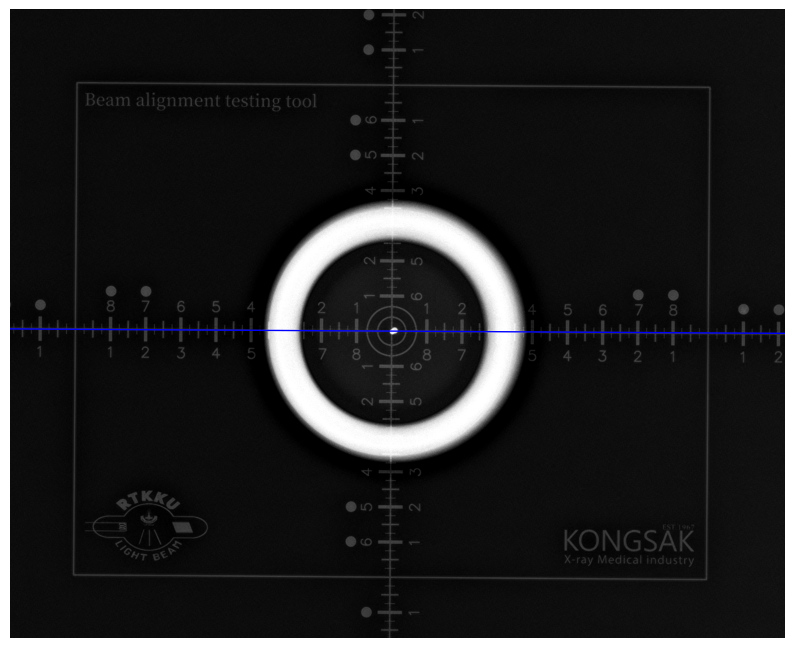

In [18]:
(x1, y1), (x2, y2), (theta_d) = find_center_line(arr)
plt.figure(figsize=(10, 10))
draw_line(arr, x1, y1, x2, y2)

In [19]:
theta_d

0.3969620975974324

### Rotate image by theta_d

In [20]:
# CCW rotate
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())
h, w = rotate_img.shape

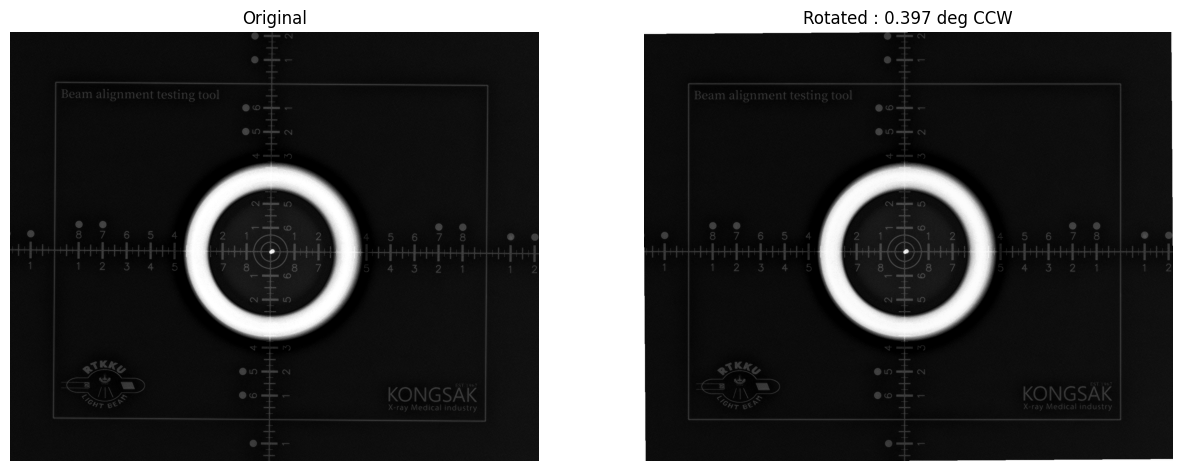

In [21]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.3f} deg CCW")
display(rotate_img)

### Find Lines in Rotated Image

In [22]:
def find_horizontal_lines(arr: np.array):
    """
    find horizontal lines[y-axis]
    return: top, center, bottom [y1, y2]
    """
    ypoints = []
    h, w = arr.shape
    hp = int(0.27*h)
    wp = int(0.07*w)
    offset = 20 # padding from rotating error (for top and bottom)

    # top line
    focus_l = arr[offset: hp, wp*2: wp*3]
    y1 = most_common(focus_l, axis=0) + offset
    focus_r = arr[offset: hp, w-(wp*3): w-(wp*2)]
    y2 = most_common(focus_l, axis=0) + offset
    ypoints.append((y1, y2))

    # center line
    (_, y1), (_, y2), _ = find_center_line(arr)
    ypoints.append((y1, y2))

    # bottom line
    focus_l = arr[h-hp: h-offset, wp*4: wp*5]
    y1 = most_common(focus_l, axis=0) + h-hp
    focus_r = arr[h-hp: h-offset, w-(wp*3): w-(wp*2)]
    y2 = most_common(focus_r, axis=0) + h-hp
    ypoints.append((y1, y2))

    return ypoints

In [23]:
ypoints = find_horizontal_lines(rotate_img)
ypoints

[(154, 154), (656, 657), (1158, 1159)]

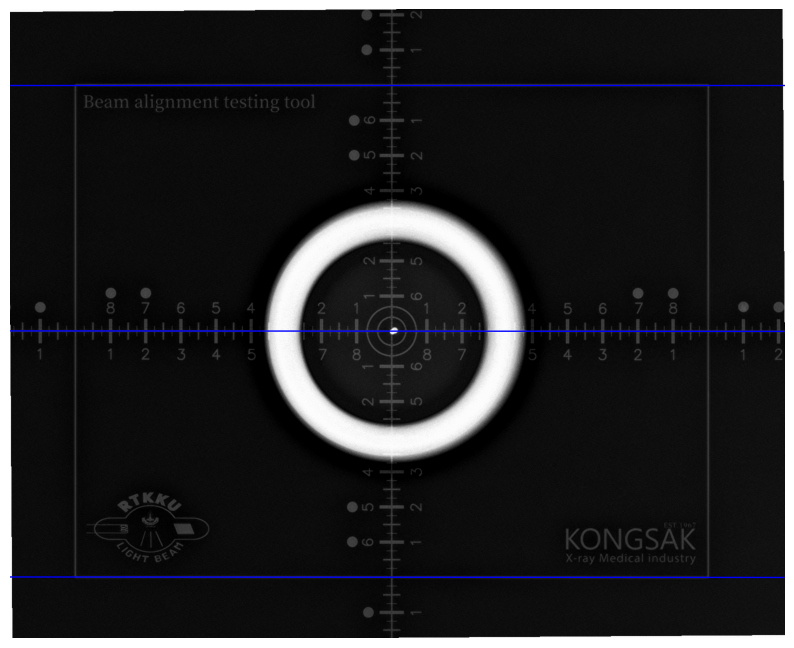

In [24]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, 0, ypoints[idx][0], w-1, ypoints[idx][1])

In [25]:
def find_vertical_line(arr: np.array):
    """
    find vertical lines[x-axis]
    Return: (top(x1, x2), center(x1, x2), bottom(x1, x2))
    """
    xpoints = []
    h, w = arr.shape
    hp = int(0.05*h) # crop ratio
    wp = int(0.04*w)

    # left line
    focus_t = arr[hp*3: hp*7, wp: wp*6]
    x1 = most_common(focus_t, axis=1) + wp
    focus_b = arr[h-hp*7: h-hp*3, wp: wp*6]
    x2 = most_common(focus_b, axis=1) + wp
    xpoints.append((x1, x2))

    # right line
    focus_t = arr[hp*3: hp*7, w-(wp*6): w-wp]
    x1 = most_common(focus_t, axis=1) + w-(wp*6)
    focus_b = arr[h-hp*7: h-hp*3, w-(wp*6): w-wp]
    x2 = most_common(focus_b, axis=1) + w-(wp*6)
    xpoints.append((x1, x2))

    # center line
    hp = int(0.18*h)
    wp = int(0.2*w)

    focus_t = arr[hp: hp*2, wp*2: wp*3]
    x1 = most_common(focus_t, axis=1) + (wp*2)
    focus_b = arr[h-(hp*2): h-hp, wp*2: wp*3]
    x2 = most_common(focus_b, axis=1) + (wp*2)
    xpoints.append((x1, x2))

    # swap bottom and center in xpoints
    centerpoints = xpoints[-1]
    xpoints[-1] = xpoints[1]
    xpoints[1] = centerpoints
    return xpoints

In [26]:
xpoints = find_vertical_line(rotate_img)
xpoints

[(133, 133), (778, 778), (1424, 1424)]

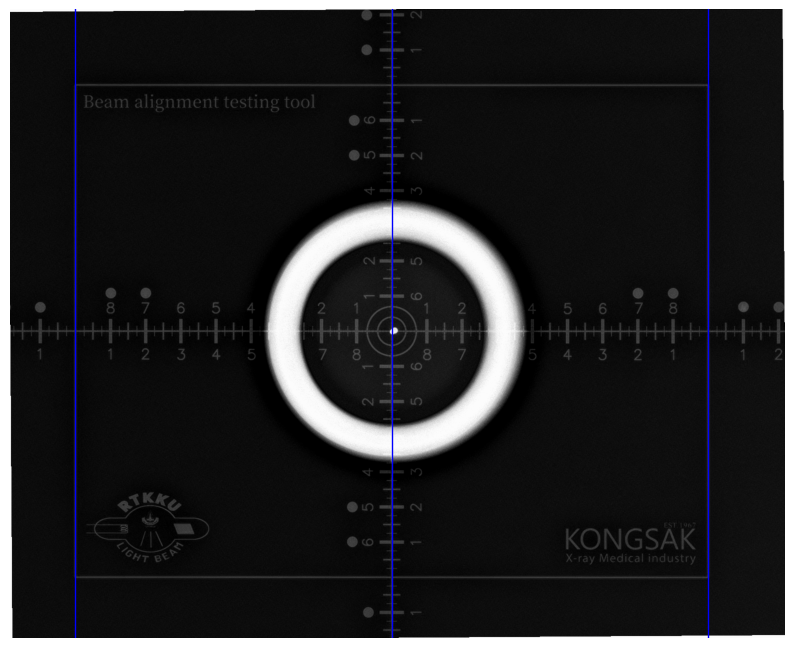

In [35]:
plt.figure(figsize=(10, 10))
for idx in range(len(xpoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h-1)

### Can optimize this
- TODO: select one value (y2, y1) -> y

In [28]:
xpoints = [round(np.mean(xpoints[idx])) for idx in range(3)]
ypoints = [round(np.mean(ypoints[idx])) for idx in range(3)]
xpoints, ypoints

([133, 778, 1424], [154, 656, 1158])

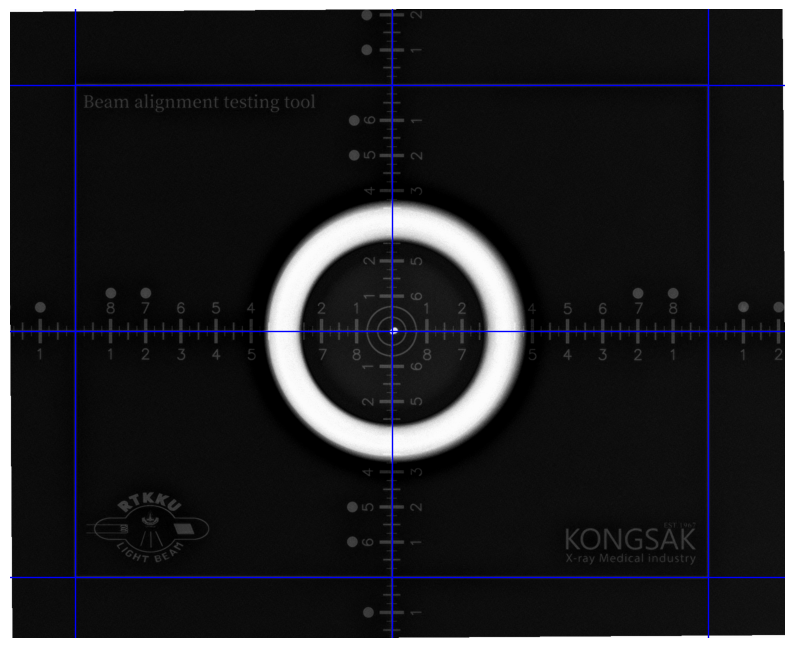

In [32]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h-1)
    draw_line(rotate_img, 0, ypoints[idx], w-1, ypoints[idx])

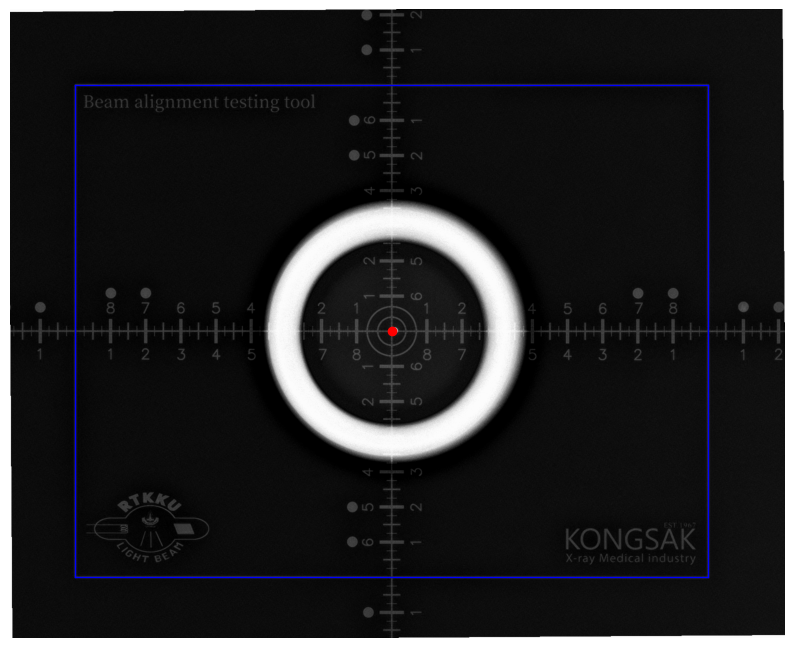

In [30]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

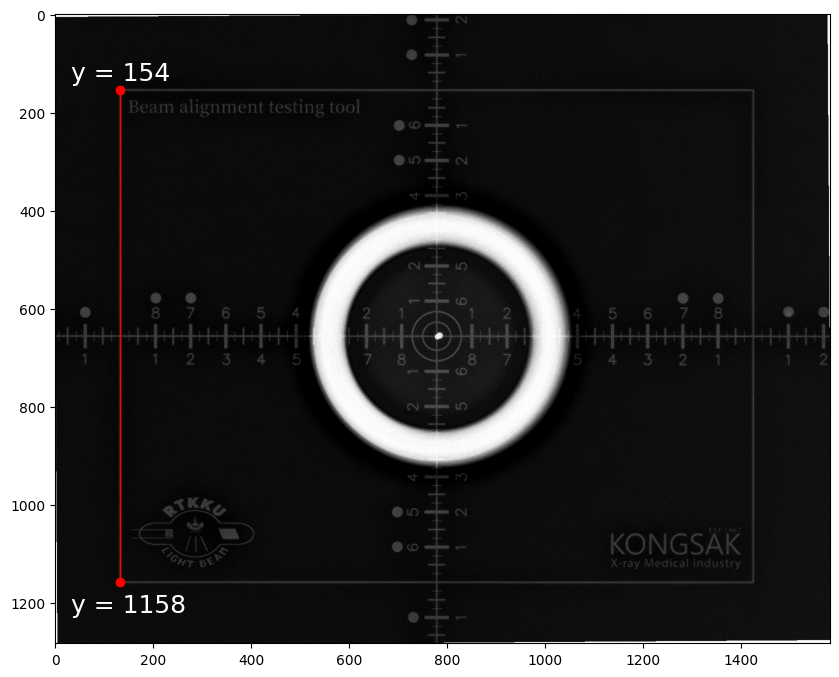

In [81]:
plt.figure(figsize=(10, 10))

draw_line(rotate_img, xpoints[0], ypoints[0], xpoints[0], ypoints[2], color="red")
plt.axis(True)
plt.text(xpoints[0]-100, ypoints[0]-20, f"y = {ypoints[0]}", fontsize = 18, color="white")
plt.plot((xpoints[0]), (ypoints[0]), 'o', color="red")
plt.text(xpoints[0]-100, ypoints[2]+60, f"y = {ypoints[2]}", fontsize = 18, color="white")
plt.plot((xpoints[0]), (ypoints[2]), 'o', color="red")

In [65]:
print(f"18cm [horizontal] equal: {xpoints[2]} - {xpoints[0]} = {xpoints[2] - xpoints[0]} pixels")
print(f"14cm [vertical] equal: {ypoints[2]} - {ypoints[0]} = {ypoints[2] - ypoints[0]} pixels")

18cm [horizontal] equal: 1424 - 133 = 1291 pixels
14cm [vertical] equal: 1158 - 154 = 1004 pixels


In [89]:
def pixel2cm(ypoints, number_pixels: int, is_rotate = False):
    """
    convert number of pixels to centimeter as aspect ratio
    """
    pixels_y = ypoints[2] - ypoints[0]
    cm_y = 14
    if is_rotate: cm_y = 18
    return round(number_pixels*cm_y/pixels_y, 2)

In [108]:
pixel2cm(ypoints, 1004)

14.0

In [101]:
def cm2pixel(ypoints, cm: float, is_rotate = False):
    """
    convert centimeter to number of pixels as aspect ratio
    """
    pixels_y = ypoints[2] - ypoints[0]
    cm_y = 14
    if is_rotate: cm_y = 18
    return round(pixels_y*cm/cm_y)

In [109]:
cm2pixel(ypoints, 14)

1004

## Field 14x18 cm